# Employee Attrition Project

by **Kevin Lacadin & Rosiel Villareal** | October 2019

The main question we want to answer is:
- **How might we address attrition to reduce overall costs in human resources?**

Specifically, we want to know:
- What kinds of people resign?
- When do they resign?
- Why do they resign?

So that we can:
- Respond with person-specific interventions
- Respond on-time before attrition happens
- Address the factors that cause attrition

## Methodology

1. Importing libraries & dataset
2. Preprocessing
    - Cleaning
    - Feature extraction
    - Feature engineering
3. Exploratory Analysis
    - Distribution analysis per feature
    - Analysis per cohort
4. Modeling & Evaluation
    - Logistic Regression
    - Decision Trees Classification
    - Random Forest Classification

## 1. Importing libraries & dataset

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#Importing csv files of client 2
client_department = pd.read_csv('client_department.csv')
client_tbl = pd.read_csv('client_tbl.csv')
employee_attendance = pd.read_csv('employee_attendance.csv')
employee_contact = pd.read_csv('employee_contact.csv')
employee_dependents = pd.read_csv('employee_dependents.csv')
employee_leave = pd.read_csv('employee_leave.csv')
employee_leavebalance = pd.read_csv('employee_leavebalance.csv')
employee_shiftcode = pd.read_csv('employee_shiftcode.csv')
employee_status = pd.read_csv('employee_status.csv')
employee_tbl = pd.read_csv('employee_tbl.csv')
position = pd.read_csv('position.csv')

## 2. Preprocessing

The features of the dataset can be divided into three categories:

**1. Employment status history**
    - Length of stay in company
    - Position
    - Monthly salary

**2. Attendance** 
    - Hours overtime
    - Hours leave
    
**3. Demographic**
    - Gender
    - Civil status
    - Age when hired
    - Number of dependents

### 2.1 Employment status history

#### 2.1.1 Length of stay in company

In [3]:
#Compute length of stay in company
from datetime import date, datetime

def days_company(datehire, time_updated, jobstatus):
    if jobstatus == 1: #if active, subtract date of hire from date today
        return abs(date.today() - datetime.strptime(datehire, '%Y-%m-%d').date())
    else: #else, subtract date of hire from date job status was updated
        return abs(datetime.strptime(time_updated[:10], '%Y-%m-%d').date() - datetime.strptime(datehire, '%Y-%m-%d').date())

employee_status['days_company'] = employee_status.apply(lambda row: days_company(row['datehire'],row['time_updated'],row['jobstatus']), axis=1)

days_to_mos = lambda x: x/30
employee_status['days_company'] = pd.to_numeric(employee_status['days_company'].dt.days, downcast='integer')
employee_status['months_company'] = employee_status.apply(lambda row: days_to_mos(row['days_company']),axis=1)

mos_to_yrs = lambda x: x/12
employee_status['years_company'] = employee_status.apply(lambda row: mos_to_yrs(row['months_company']),axis=1)

#### 2.2.2 - 2.2.3 Position + monthly salary (oldest & latest)

In [4]:
#Get the latest info on employees
latest_update = employee_status.sort_values(['employee_number', 'time_updated'])
latest_update.drop_duplicates(subset ="employee_number", keep = 'last', inplace = True)
latest_update.rename(columns={'basic_rate':'latest_rate', 'time_updated':'latest_time', 'position_id':'latest_position_id'},inplace=True)
latest_update = latest_update.drop(columns=['joblevel','paymode','position_level','history','datehire'])

#Get the oldest info on employees
oldest_update = employee_status.sort_values(['employee_number', 'time_updated'])
oldest_update.drop_duplicates(subset ="employee_number", keep = 'first', inplace = True) 
oldest_update.rename(columns={'basic_rate':'oldest_rate', 'time_updated':'oldest_time'},inplace=True)
oldest_update = oldest_update.drop(columns=['jobstatus','joblevel','paymode','date_jobstatus','days_company','months_company','years_company','position_level','history','client_code','department_code','position_id'])

status_df = pd.merge(latest_update, oldest_update, how='left', on='employee_number')

In [5]:
#Categorize most common positions
customer_rel = [97,98,99,100,101,102,103,104,105,106,173,174,175,176,189,193,196,236]
catering = [12,13,14,15,16,18,37,65,207,208,218,234,235]
execs = [145,169,179,206]
finance = [9,10,84,212,215,56,57,58,147,210,211]
hr = [31,32,33,126,128,129,197,242]
supervisor = [17,28,41,49,51,63,64,69,172,190,194,199,200,201,202,203,205,222,223,225]
manager = [19,26,29,42,43,50,177,178,198,230,239]
maintenance = [86,87,88,89,90,91,92,93,94,182,183,184,185,186,187,188,30,116,117,118,119,123,124,125,132,209,217]

def categorize_pos(pos):
    if pos in customer_rel:
        return "Customer relations"
    elif pos in catering:
        return "Catering"
    elif pos in execs:
        return "Executives"
    elif pos in finance:
        return "Finance"
    elif pos in hr:
        return "HR"
    elif pos in supervisor:
        return "Supervisor"
    elif pos in manager:
        return "Manager"
    elif pos in maintenance:
        return "Maintenance"
    else:
        return "Others"
    
status_df['position'] = status_df.apply(lambda row: categorize_pos(row['latest_position_id']),axis=1)

In [6]:
#Drop rows w/ 0 salary as oldest pay rate
status_df = status_df.loc[status_df['oldest_rate']!=0]

#Compute % salary increase of employees
def salary_increase(latest_rate, oldest_rate):
    return 100*((latest_rate - oldest_rate)/oldest_rate)

status_df['percent_salary_increase'] = status_df.apply(lambda row: salary_increase(row['latest_rate'], row['oldest_rate']), axis=1)
status_df.head()

,employee_number,jobstatus,client_code,department_code,latest_rate,date_jobstatus,latest_time,latest_position_id,days_company,months_company,years_company,datehire,oldest_rate,oldest_time,position,percent_salary_increase
0,employee10,2,SLPI-AF,ACCTNG,13317.00,2017-02-25,2017-02-28 12:05:37,212,981,32.700000,2.725000,2014-06-23,13317.00,2016-11-11 15:30:25,Finance,0.000000
1,employee100,1,MNL-PSD,MNL-PSD,19497.30,2011-10-17,2018-12-13 15:24:02,199,2929,97.633333,8.136111,2011-10-17,12546.07,2016-11-11 15:30:38,Supervisor,55.405637
2,employee1000,5,SKPI-CF,CFS - 2ND SHIFT,13524.90,2018-01-26,2018-02-19 11:59:30,13,628,20.933333,1.744444,2016-06-01,12977.15,2016-12-22 16:17:49,Catering,4.220881
3,employee1001,1,MNL-RMP,MNL-RMP-GEO2,23199.83,2012-10-16,2018-12-14 13:16:36,194,2564,85.466667,7.122222,2012-10-16,15900.00,2016-11-11 15:30:44,Supervisor,45.910881
4,employee1002,1,SKPI-CF,CFS - 1ST SHIFT,14006.73,2016-05-12,2018-12-11 17:09:15,12,1260,42.000000,3.500000,2016-05-12,12546.07,2016-12-22 14:37:35,Catering,11.642371


### 2.2 Attendance

#### 2.2.1 Hours overtime

In [7]:
#Get hours overtime from employee_attendance
overtime_df = employee_attendance.groupby('employee_number')['appot'].agg(['sum'])
overtime_df = overtime_df.rename(columns={'sum':'total_hrs_overtime'})

#Get ratio of hrs overtime to days in company
status_df = pd.merge(status_df, overtime_df, how='left', on='employee_number')

def compute_overtime (days_company, total_hrs_overtime):
    return total_hrs_overtime/days_company

status_df['overtime_ratio'] = status_df.apply(lambda row: compute_overtime(row['days_company'], row['total_hrs_overtime']), axis=1)

#### 2.2.2 Hours leave

In [8]:
#Compute no. of leaves & no. of total hrs leave from employee_leave
leaves_df = employee_leave.groupby('employee_number')['number_of_hours'].agg(['sum','size'])
leaves_df = leaves_df.rename(columns={'sum':'total_hrs_leave','size':'no_leaves'})

#Get ratio of hrs leave to days in company
status_df = pd.merge(status_df, leaves_df, how='left', on='employee_number')

def compute_leaves (days_company, total_hrs_leave):
    return total_hrs_leave/days_company

status_df['leave_ratio'] = status_df.apply(lambda row: compute_leaves(row['days_company'], row['total_hrs_leave']), axis=1)
status_df.head()

,employee_number,jobstatus,client_code,department_code,latest_rate,date_jobstatus,latest_time,latest_position_id,days_company,months_company,...,datehire,oldest_rate,oldest_time,position,percent_salary_increase,total_hrs_overtime,overtime_ratio,total_hrs_leave,no_leaves,leave_ratio
0,employee10,2,SLPI-AF,ACCTNG,13317.00,2017-02-25,2017-02-28 12:05:37,212,981,32.700000,...,2014-06-23,13317.00,2016-11-11 15:30:25,Finance,0.000000,0.0,0.000000,NaN,NaN,NaN
1,employee100,1,MNL-PSD,MNL-PSD,19497.30,2011-10-17,2018-12-13 15:24:02,199,2929,97.633333,...,2011-10-17,12546.07,2016-11-11 15:30:38,Supervisor,55.405637,1893.5,0.646466,414.0,47.0,0.141345
2,employee1000,5,SKPI-CF,CFS - 2ND SHIFT,13524.90,2018-01-26,2018-02-19 11:59:30,13,628,20.933333,...,2016-06-01,12977.15,2016-12-22 16:17:49,Catering,4.220881,200.5,0.319268,414.0,47.0,0.659236
3,employee1001,1,MNL-RMP,MNL-RMP-GEO2,23199.83,2012-10-16,2018-12-14 13:16:36,194,2564,85.466667,...,2012-10-16,15900.00,2016-11-11 15:30:44,Supervisor,45.910881,147.5,0.057527,360.0,41.0,0.140406
4,employee1002,1,SKPI-CF,CFS - 1ST SHIFT,14006.73,2016-05-12,2018-12-11 17:09:15,12,1260,42.000000,...,2016-05-12,12546.07,2016-12-22 14:37:35,Catering,11.642371,654.0,0.519048,625.5,73.0,0.496429


### 2.3 Demographic

#### 2.3.1 - 2.3.2 Gender + civil status

In [9]:
employee_tbl = employee_tbl.drop(columns=['citizenship'])
employee_tbl = employee_tbl.dropna(axis=0, how='any')

employee_tbl['civil_status'].replace('S','1', inplace=True)
employee_tbl['civil_status'].replace('M','2', inplace=True)
employee_tbl['civil_status'].replace('1','Single', inplace=True)
employee_tbl['civil_status'].replace('2','Married', inplace=True)
employee_tbl['civil_status'].replace('3','Others', inplace=True)
employee_tbl['civil_status'].replace('4','Others', inplace=True)

#### 2.3.3 Age when hired 

In [10]:
employee_df = pd.merge(status_df, employee_tbl, how='left', on='employee_number')

In [11]:
#Compute age at time of joining
from datetime import date, datetime

def compute_age (datehire, birth_date):
    return abs(datetime.strptime(datehire, '%Y-%m-%d').date()- datetime.strptime(birth_date, '%m/%d/%Y').date())/365

employee_df['age_joining'] = employee_df.apply(lambda row: compute_age (row['datehire'],row['birth_date']), axis=1) 
employee_df['age_joining'] = pd.to_numeric(employee_df['age_joining'].dt.days, downcast='integer')

#### 2.3.4 Number of dependents

In [12]:
employee_df = pd.merge(employee_df, employee_dependents, how='left', on='employee_number')
employee_df['number_of_dependents'].fillna(0,inplace=True)

In [13]:
employee_df.columns

Index(['employee_number', 'jobstatus', 'client_code', 'department_code',
       'latest_rate', 'date_jobstatus', 'latest_time', 'latest_position_id',
       'days_company', 'months_company', 'years_company', 'datehire',
       'oldest_rate', 'oldest_time', 'position', 'percent_salary_increase',
       'total_hrs_overtime', 'overtime_ratio', 'total_hrs_leave', 'no_leaves',
       'leave_ratio', 'birth_date', 'gender', 'civil_status', 'age_joining',
       'number_of_dependents'],
      dtype='object')

## 3. Exploratory Analysis

In [14]:
#Include only employees with jobstatus of 1 (active) or 2,5,6,7 (resigned, retired, terminated, end of contract)
df = employee_df.loc[employee_df['jobstatus'].isin([1,2,5,6,7])]

In [15]:
df.describe()

,jobstatus,latest_rate,latest_position_id,days_company,months_company,years_company,oldest_rate,percent_salary_increase,total_hrs_overtime,overtime_ratio,total_hrs_leave,no_leaves,leave_ratio,age_joining,number_of_dependents
count,3238.000000,3238.000000,3238.000000,3238.000000,3238.000000,3238.000000,3238.000000,3.238000e+03,2925.000000,2925.000000,2371.000000,2371.000000,2371.000000,3238.000000,3238.000000
mean,1.406424,16128.680874,117.058369,1342.985485,44.766183,3.730515,14403.909373,6.298559e+03,397.576896,0.366563,228.013918,26.133699,0.176119,29.973132,0.243360
std,0.994446,7749.556764,51.798092,976.585169,32.552839,2.712737,7828.473997,9.439388e+04,524.205389,0.393976,184.251853,21.175364,0.151636,10.791630,0.701786
min,1.000000,0.000000,9.000000,23.000000,0.766667,0.063889,1.000000,-1.000000e+02,0.000000,0.000000,4.500000,1.000000,0.004388,12.000000,0.000000
25%,1.000000,13171.375000,94.000000,463.000000,15.433333,1.286111,12546.070000,3.289963e+00,82.500000,0.084380,72.000000,8.000000,0.079457,22.000000,0.000000
50%,1.000000,14176.980000,100.000000,994.000000,33.133333,2.761111,13093.820000,6.972068e+00,196.500000,0.249576,211.500000,24.000000,0.133975,25.000000,0.000000
75%,1.000000,17139.830000,132.000000,2295.500000,76.516667,6.376389,15000.000000,1.444381e+01,495.500000,0.509810,333.000000,38.000000,0.234133,36.000000,0.000000
max,7.000000,81376.630000,242.000000,2957.000000,98.566667,8.213889,180000.000000,3.680866e+06,3724.500000,3.820000,1467.000000,177.000000,2.212963,71.000000,4.000000


C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0, 0.5, 'Years in company'), Text(0.5, 0, 'Job status')]

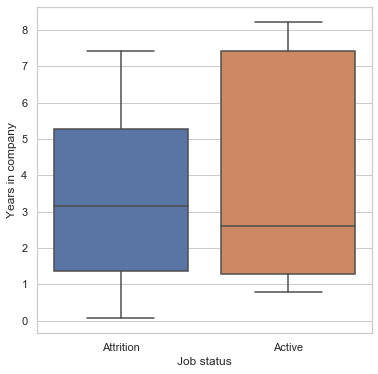

In [16]:
is_active = lambda x: "Active" if x==1 else "Attrition"

df['is_active'] = df.apply(lambda row: is_active(row['jobstatus']), axis=1)

#Boxplot of length of stay in company 
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x=df['is_active'],y=df['years_company'],ax=ax)
ax.set(xlabel='Job status', ylabel='Years in company')

Employees who resigned or were terminated stayed for about 4 years while employees who are still active have stayed for about 6 yrs.

Text(0, 0.5, '')

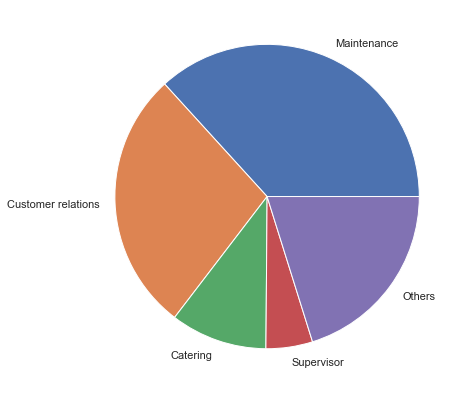

In [20]:
import pylab
        
attr = pd.DataFrame({'count': [297, 225, 83, 40,163]},
                   index=['Maintenance','Customer relations',
                         'Catering','Supervisor','Others'])
attr.plot.pie(subplots=True,figsize=(7,7), legend=False)
pylab.ylabel('')

Of the employee attrition subset…
- Maintenance 37%
- Customer relations 28%
- Catering 10%
- Supervisors 5%
- Others 20% 

[Text(0, 0.5, 'Monthly salary'), Text(0.5, 0, 'Job status')]

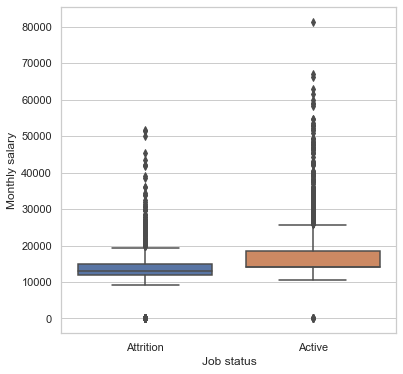

In [21]:
#Boxplot of salary
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x=df['is_active'],y=df['latest_rate'],ax=ax)
ax.set(xlabel='Job status', ylabel='Monthly salary')

[Text(0, 0.5, 'Overtime ratio'), Text(0.5, 0, 'Job status')]

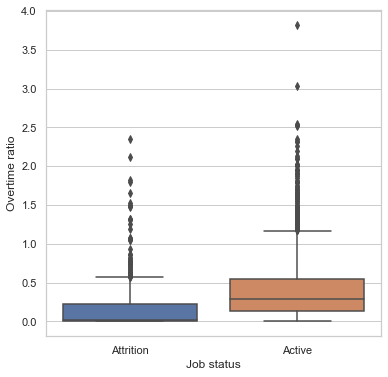

In [22]:
#Boxplot of overtime ratio
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x=df['is_active'],y=df['overtime_ratio'],ax=ax)
ax.set(xlabel='Job status', ylabel='Overtime ratio')

[Text(0, 0.5, 'Leave ratio'), Text(0.5, 0, 'Job status')]

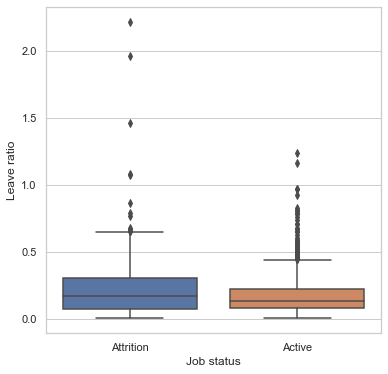

In [23]:
#Boxplot of leave ratio
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(6,6))
sns.boxplot(x=df['is_active'],y=df['leave_ratio'],ax=ax)
ax.set(xlabel='Job status', ylabel='Leave ratio')

### 3.1 Gender

[Text(0, 0.5, 'Attrition rate'), Text(0.5, 0, 'Gender')]

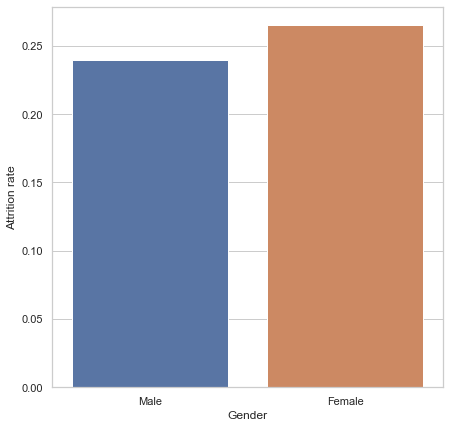

In [24]:
active_m = len(df.loc[(df['gender']=='M') & (df['jobstatus']==1)])
attrition_m = len(df.loc[(df['gender']=='M') & (df['jobstatus'].isin([2,5,6,7]))])

active_f = len(df.loc[(df['gender']=='F') & (df['jobstatus']==1)])
attrition_f = len(df.loc[(df['gender']=='F') & (df['jobstatus'].isin([2,5,6,7]))])

sns.set(style="whitegrid")
x=['Male' ,'Female']
y=[attrition_m/(active_m+attrition_m), attrition_f/(active_f+attrition_f)]
fig, ax = plt.subplots(figsize=(7,7)) 
sns.barplot(x=x, y=y)
ax.set(xlabel='Gender', ylabel='Attrition rate')

Regardless of gender, about one-fourth of employees leave.

### 3.2 Civil status

[Text(0, 0.5, 'Attrition rate'), Text(0.5, 0, 'Civil Status')]

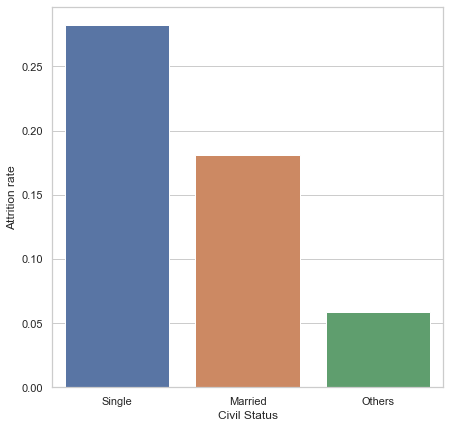

In [25]:
active_s = len(df.loc[(df['civil_status']=='Single') & (df['jobstatus']==1)])
attrition_s = len(df.loc[(df['civil_status']=='Single') & (df['jobstatus'].isin([2,5,6,7]))])

active_m = len(df.loc[(df['civil_status']=='Married') & (df['jobstatus']==1)])
attrition_m = len(df.loc[(df['civil_status']=='Married') & (df['jobstatus'].isin([2,5,6,7]))])

active_o = len(df.loc[(df['civil_status']=='Others') & (df['jobstatus']==1)])
attrition_o = len(df.loc[(df['civil_status']=='Others') & (df['jobstatus'].isin([2,5,6,7]))])

sns.set(style="whitegrid")
x=['Single' ,'Married', 'Others']
y=[attrition_s/(active_s+attrition_s), attrition_m/(active_m+attrition_m),attrition_o/(active_o+attrition_o)]
fig, ax = plt.subplots(figsize=(7,7)) 
sns.barplot(x=x, y=y)
ax.set(xlabel='Civil Status', ylabel='Attrition rate')

Attrition: 10% higher for single employees than married ones

### 3.3 Number of dependents

C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[Text(0, 0.5, 'Attrition rate'), Text(0.5, 0, 'No. of dependents')]

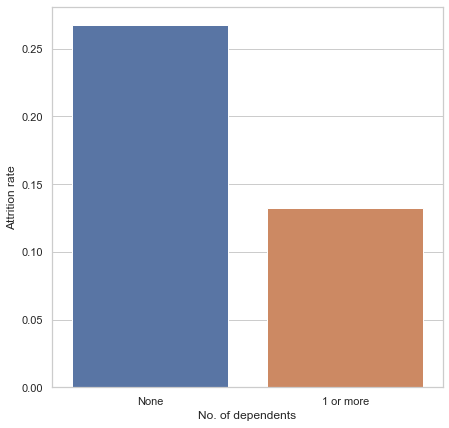

In [26]:
with_dependents = lambda x: 0 if x==0.0 else '1 or more'

df['no_of_dependents'] = df.apply(lambda row: with_dependents(row['number_of_dependents']), axis=1)

active_n = len(df.loc[(df['no_of_dependents']==0.0) & (df['jobstatus']==1)])
attrition_n = len(df.loc[(df['no_of_dependents']==0.0) & (df['jobstatus'].isin([2,5,6,7]))])

active_1 = len(df.loc[(df['no_of_dependents']=='1 or more') & (df['jobstatus']==1)])
attrition_1 = len(df.loc[(df['no_of_dependents']=='1 or more') & (df['jobstatus'].isin([2,5,6,7]))])

sns.set(style="whitegrid")
x=['None', '1 or more']
y=[attrition_n/(active_n+attrition_n), attrition_1/(active_1+attrition_1)]
fig, ax = plt.subplots(figsize=(7,7)) 
sns.barplot(x=x, y=y)
ax.set(xlabel='No. of dependents', ylabel='Attrition rate')

Attrition: 14% higher for employees with no dependents

### 3.4 Generation

In [27]:
#Gen Z (1997 onwards or 22 & below) 
#Millenials (born 1980-1996 or 23-39)
#Gen X (1965-1979 or 40-54)
#Baby boomers (1943-1962 or 55-76)

def bracket(age): #categorize into generations based on age brackets
    if 12 <= age <= 22:
        return "Gen Z"
    elif 23 <= age <= 39:
        return "Millenials"
    elif 40 <= age <= 54:
        return "Gen X"
    else:
        return "Baby boomers"

df['generation'] = df.apply(lambda row: bracket(row['age_joining']), axis=1)

C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


[Text(0, 0.5, 'Attrition rate'), Text(0.5, 0, 'Generation')]

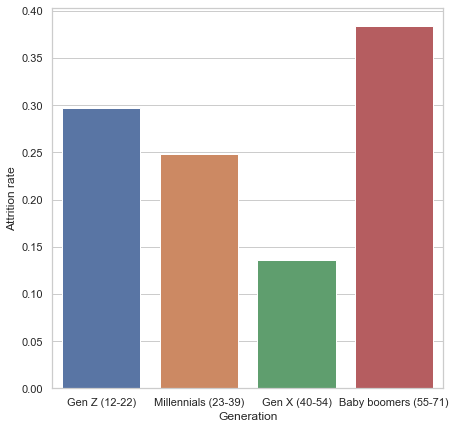

In [28]:
active_z = len(df.loc[(df['generation']=='Gen Z') & (df['jobstatus']==1)])
attrition_z = len(df.loc[(df['generation']=='Gen Z') & (df['jobstatus'].isin([2,5,6,7]))])

active_m = len(df.loc[(df['generation']=='Millenials') & (df['jobstatus']==1)])
attrition_m = len(df.loc[(df['generation']=='Millenials') & (df['jobstatus'].isin([2,5,6,7]))])

active_x = len(df.loc[(df['generation']=='Gen X') & (df['jobstatus']==1)])
attrition_x = len(df.loc[(df['generation']=='Gen X') & (df['jobstatus'].isin([2,5,6,7]))])

active_b = len(df.loc[(df['generation']=='Baby boomers') & (df['jobstatus']==1)])
attrition_b = len(df.loc[(df['generation']=='Baby boomers') & (df['jobstatus'].isin([2,5,6,7]))])

sns.set(style="whitegrid")
x=['Gen Z (12-22)','Millennials (23-39)','Gen X (40-54)','Baby boomers (55-71)']
y=[attrition_z/(active_z+attrition_z), attrition_m/(active_m+attrition_m), attrition_x/(active_x+attrition_x), attrition_b/(active_b+attrition_b)]

fig, ax = plt.subplots(figsize=(7,7)) 
sns.barplot(x=x, y=y)
ax.set(xlabel='Generation', ylabel='Attrition rate')

Of Gen Z & millennial employees, more than one-fourth leave.

## 4. Modeling & Evaluation

In [29]:
#Create new variables indicating 1 for yes or 0 for no if employee resigned within specified time (6 mos, 1 yr, 2 yrs, 3 yrs)
resigned_in_6_mos = lambda x: 1 if x <=6 else 0
resigned_in_1_yr = lambda x: 1 if x <=1 else 0
resigned_in_2_yr = lambda x: 1 if x <=2 else 0
resigned_in_3_yr = lambda x: 1 if x <=3 else 0

df['resigned_in_6_mos'] = df.apply(lambda row: resigned_in_6_mos(row['months_company']), axis=1)
df['resigned_in_1_yr'] = df.apply(lambda row: resigned_in_1_yr(row['years_company']), axis=1)
df['resigned_in_2_yr'] = df.apply(lambda row: resigned_in_2_yr(row['years_company']), axis=1)
df['resigned_in_3_yr'] = df.apply(lambda row: resigned_in_3_yr(row['years_company']), axis=1)
df.head()

C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

,employee_number,jobstatus,client_code,department_code,latest_rate,date_jobstatus,latest_time,latest_position_id,days_company,months_company,...,civil_status,age_joining,number_of_dependents,is_active,no_of_dependents,generation,resigned_in_6_mos,resigned_in_1_yr,resigned_in_2_yr,resigned_in_3_yr
0,employee10,2,SLPI-AF,ACCTNG,13317.00,2017-02-25,2017-02-28 12:05:37,212,981,32.700000,...,Single,25,0.0,Attrition,0,Millenials,0,0,0,1
1,employee100,1,MNL-PSD,MNL-PSD,19497.30,2011-10-17,2018-12-13 15:24:02,199,2929,97.633333,...,Single,19,0.0,Active,0,Gen Z,0,0,0,0
2,employee1000,5,SKPI-CF,CFS - 2ND SHIFT,13524.90,2018-01-26,2018-02-19 11:59:30,13,628,20.933333,...,Married,40,0.0,Attrition,0,Gen X,0,0,1,1
3,employee1001,1,MNL-RMP,MNL-RMP-GEO2,23199.83,2012-10-16,2018-12-14 13:16:36,194,2564,85.466667,...,Single,24,0.0,Active,0,Millenials,0,0,0,0
4,employee1002,1,SKPI-CF,CFS - 1ST SHIFT,14006.73,2016-05-12,2018-12-11 17:09:15,12,1260,42.000000,...,Single,28,0.0,Active,0,Millenials,0,0,0,0


In [30]:
#Drop all other columns that will not be used in modeling
df = df.drop(columns=['department_code','date_jobstatus','latest_time','latest_position_id','is_active', 'no_of_dependents',
                                   'days_company','datehire','oldest_time','birth_date','total_hrs_overtime','total_hrs_leave','no_leaves'])
df.head()

,employee_number,jobstatus,client_code,latest_rate,months_company,years_company,oldest_rate,position,percent_salary_increase,overtime_ratio,leave_ratio,gender,civil_status,age_joining,number_of_dependents,generation,resigned_in_6_mos,resigned_in_1_yr,resigned_in_2_yr,resigned_in_3_yr
0,employee10,2,SLPI-AF,13317.00,32.700000,2.725000,13317.00,Finance,0.000000,0.000000,NaN,F,Single,25,0.0,Millenials,0,0,0,1
1,employee100,1,MNL-PSD,19497.30,97.633333,8.136111,12546.07,Supervisor,55.405637,0.646466,0.141345,F,Single,19,0.0,Gen Z,0,0,0,0
2,employee1000,5,SKPI-CF,13524.90,20.933333,1.744444,12977.15,Catering,4.220881,0.319268,0.659236,M,Married,40,0.0,Gen X,0,0,1,1
3,employee1001,1,MNL-RMP,23199.83,85.466667,7.122222,15900.00,Supervisor,45.910881,0.057527,0.140406,M,Single,24,0.0,Millenials,0,0,0,0
4,employee1002,1,SKPI-CF,14006.73,42.000000,3.500000,12546.07,Catering,11.642371,0.519048,0.496429,M,Single,28,0.0,Millenials,0,0,0,0


In [31]:
#Job status
status_df = df[['employee_number','jobstatus']]

In [32]:
#Scale continuous variables
norm_df = df[['employee_number', 'latest_rate', 'oldest_rate', 'number_of_dependents', 
                  'age_joining', 'months_company', 'overtime_ratio', 'years_company', 
                  'percent_salary_increase', 'leave_ratio']]

from sklearn import preprocessing
robust_scaler = preprocessing.RobustScaler()
#Scales features using statistics that are robust to outliers.
#This scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

norm_df[['latest_rate', 'oldest_rate', 'number_of_dependents','age_joining', 'months_company', 'overtime_ratio', 
         'years_company', 'percent_salary_increase', 'leave_ratio']] = robust_scaler.fit_transform(norm_df[['latest_rate', 'oldest_rate', 'number_of_dependents', 
        'age_joining', 'months_company', 'overtime_ratio', 'years_company', 'percent_salary_increase', 'leave_ratio']])

norm_df.head()

C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,employee_number,latest_rate,oldest_rate,number_of_dependents,age_joining,months_company,overtime_ratio,years_company,percent_salary_increase,leave_ratio
0,employee10,-0.216704,0.090948,0.0,0.000000,-0.007094,-0.586643,-0.007094,-0.625082,NaN
1,employee100,1.340653,-0.223213,0.0,-0.428571,1.055935,0.932917,1.055935,4.342318,0.047646
2,employee1000,-0.164316,-0.047544,0.0,1.071429,-0.199727,0.163815,-0.199727,-0.246658,3.395866
3,employee1001,2.273643,1.143545,0.0,-0.071429,0.856753,-0.451422,0.856753,3.491064,0.041572
4,employee1002,-0.042901,-0.223213,0.0,0.214286,0.145157,0.633411,0.145157,0.418717,2.343300


In [33]:
#Encode categorical variables
cat = ['client_code','gender', 'civil_status','position']
cat_df = df[['employee_number','client_code','gender', 'civil_status','position','resigned_in_6_mos',
                'resigned_in_1_yr','resigned_in_2_yr','resigned_in_3_yr']]
cat_df = pd.get_dummies(cat_df, columns=cat)
#Converts categorical variable into dummy/indicator variables.
cat_df.head()

,employee_number,resigned_in_6_mos,resigned_in_1_yr,resigned_in_2_yr,resigned_in_3_yr,client_code_CEB-CRG,client_code_CEB-EO,client_code_CEB-GEM,client_code_CEB-HR,client_code_CEB-MAB,...,civil_status_Single,position_Catering,position_Customer relations,position_Executives,position_Finance,position_HR,position_Maintenance,position_Manager,position_Others,position_Supervisor
0,employee10,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
1,employee100,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,employee1000,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,employee1001,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
4,employee1002,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [34]:
#Merge scaled continuous variables, encoded categorical variables, and job status
final_df = pd.merge(cat_df, norm_df, how='left', on='employee_number')
final_df = pd.merge(final_df, status_df, how='left', on='employee_number')
final_df.head()

,employee_number,resigned_in_6_mos,resigned_in_1_yr,resigned_in_2_yr,resigned_in_3_yr,client_code_CEB-CRG,client_code_CEB-EO,client_code_CEB-GEM,client_code_CEB-HR,client_code_CEB-MAB,...,latest_rate,oldest_rate,number_of_dependents,age_joining,months_company,overtime_ratio,years_company,percent_salary_increase,leave_ratio,jobstatus
0,employee10,0,0,0,1,0,0,0,0,0,...,-0.216704,0.090948,0.0,0.000000,-0.007094,-0.586643,-0.007094,-0.625082,NaN,2
1,employee100,0,0,0,0,0,0,0,0,0,...,1.340653,-0.223213,0.0,-0.428571,1.055935,0.932917,1.055935,4.342318,0.047646,1
2,employee1000,0,0,1,1,0,0,0,0,0,...,-0.164316,-0.047544,0.0,1.071429,-0.199727,0.163815,-0.199727,-0.246658,3.395866,5
3,employee1001,0,0,0,0,0,0,0,0,0,...,2.273643,1.143545,0.0,-0.071429,0.856753,-0.451422,0.856753,3.491064,0.041572,1
4,employee1002,0,0,0,0,0,0,0,0,0,...,-0.042901,-0.223213,0.0,0.214286,0.145157,0.633411,0.145157,0.418717,2.343300,1


In [35]:
#Check if there are missing values in final dataframe
final_df.isnull().sum()

employee_number                  0
resigned_in_6_mos                0
resigned_in_1_yr                 0
resigned_in_2_yr                 0
resigned_in_3_yr                 0
client_code_CEB-CRG              0
client_code_CEB-EO               0
client_code_CEB-GEM              0
client_code_CEB-HR               0
client_code_CEB-MAB              0
client_code_CEB-OSM              0
client_code_CEB-PSD              0
client_code_CEB-RMP              0
client_code_CEB-SA               0
client_code_CEB-STN              0
client_code_MNL-CBS              0
client_code_MNL-CSD              0
client_code_MNL-GEM              0
client_code_MNL-PSD              0
client_code_MNL-RMP              0
client_code_MNL-SC               0
client_code_SKPI-AC              0
client_code_SKPI-AF              0
client_code_SKPI-CA              0
client_code_SKPI-CF              0
client_code_SKPI-CP              0
client_code_SKPI-CS              0
client_code_SKPI-FM              0
client_code_SKPI-GE 

In [36]:
#Fill missing values with 0
final_df['leave_ratio'].fillna(0,inplace=True)
final_df['overtime_ratio'].fillna(0,inplace=True)

In [37]:
#For training the models, use attrition subset only (2 resigned, 5 terminated, 6 retired, 7 end of probation)
attrition_df = final_df.loc[final_df['jobstatus'].isin([2,5,6,7])] 
active_df = final_df.loc[final_df['jobstatus']==1]
attrition_df.shape

(808, 78)

In [38]:
from sklearn import model_selection as ms, linear_model as lm, tree, ensemble

#Stratified 10-fold validation to evaluate model
ten_fold_cv = ms.StratifiedKFold(n_splits=10, shuffle=True)

In [39]:
#Assign inputs to X, outputs to y
X6 = attrition_df.drop(['employee_number','jobstatus','years_company','months_company','resigned_in_6_mos', 'resigned_in_1_yr','resigned_in_2_yr', 'resigned_in_3_yr'],axis=1)
y6 = attrition_df['resigned_in_6_mos']

X1 = attrition_df.drop(['employee_number','jobstatus','years_company','months_company','resigned_in_6_mos', 'resigned_in_1_yr','resigned_in_2_yr', 'resigned_in_3_yr'],axis=1)
y1 = attrition_df['resigned_in_1_yr']

X2 = attrition_df.drop(['employee_number','jobstatus','years_company','months_company','resigned_in_6_mos', 'resigned_in_1_yr','resigned_in_2_yr', 'resigned_in_3_yr'],axis=1)
y2 = attrition_df['resigned_in_2_yr']

X3 = attrition_df.drop(['employee_number','jobstatus','years_company','months_company','resigned_in_6_mos', 'resigned_in_1_yr','resigned_in_2_yr', 'resigned_in_3_yr'],axis=1)
y3 = attrition_df['resigned_in_3_yr']

### 4.1 Logistic Regression

#### 4.1.1 Resigned in 6 mos?

In [40]:
logreg = lm.LogisticRegression(C=1e50, solver='liblinear')
logreg.fit(X6,y6)
aucs = ms.cross_val_score(lm.LogisticRegression(C=1e50, solver='liblinear'), X6, y6, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Rosiel Jazmine V\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.727246853017401

#### 4.1.2 Resigned in 1 yr?

In [41]:
logreg = lm.LogisticRegression(C=1e50, solver='liblinear')
logreg.fit(X1,y1)
aucs = ms.cross_val_score(lm.LogisticRegression(C=1e50, solver='liblinear'), X1, y1, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.7952074592074592

#### 4.1.3 Resigned in 2 yrs?

In [42]:
logreg = lm.LogisticRegression(C=1e50, solver='liblinear')
logreg.fit(X2,y2)
aucs = ms.cross_val_score(lm.LogisticRegression(C=1e50, solver='liblinear'), X2, y2, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.7898200447287668

#### 4.1.4 Resigned in 3 yrs?

In [43]:
logreg = lm.LogisticRegression(C=1e50, solver='liblinear')
logreg.fit(X3,y3)
aucs = ms.cross_val_score(lm.LogisticRegression(C=1e50, solver='liblinear'), X3, y3, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.7746952336281604

### 4.2 Decision Trees Classification

#### 4.2.1 Resigned in 6 mos?

In [44]:
tree6 = tree.DecisionTreeClassifier()
tree6.fit(X6, y6)
aucs = ms.cross_val_score(tree.DecisionTreeClassifier(), X6, y6, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.6505487385624372

#### 4.2.2 Resigned in 1 yr?

In [45]:
tree1 = tree.DecisionTreeClassifier()
tree1.fit(X1, y1)
aucs = ms.cross_val_score(tree.DecisionTreeClassifier(), X1, y1, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.7264599844599845

#### 4.2.3 Resigned in 2 yrs?

In [46]:
tree2 = tree.DecisionTreeClassifier()
tree2.fit(X2, y2)
aucs = ms.cross_val_score(tree.DecisionTreeClassifier(), X2, y2, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.7299931086492952

#### 4.2.4 Resigned in 3 yrs?

In [47]:
tree3 = tree.DecisionTreeClassifier()
tree3.fit(X3, y3)
aucs = ms.cross_val_score(tree.DecisionTreeClassifier(), X3, y3, scoring='roc_auc', cv=ten_fold_cv)
np.mean(aucs)

0.8016102139730188

### 4.3 Random Forest Classification

#### 4.3.1 Resigned in 6 mos?

In [48]:
for n_trees in [2, 5, 10, 20, 50, 100]:
    aucs = ms.cross_val_score(
        ensemble.RandomForestClassifier(n_estimators=n_trees), X6, y6, scoring='roc_auc', cv=ten_fold_cv)
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs)))

  2 trees: mean AUC 67.02%
  5 trees: mean AUC 76.60%
 10 trees: mean AUC 81.88%
 20 trees: mean AUC 84.16%
 50 trees: mean AUC 85.31%
100 trees: mean AUC 85.54%


#### 4.3.2 Resigned in 1 yr?

In [49]:
for n_trees in [2, 5, 10, 20, 50, 100]:
    aucs = ms.cross_val_score(
        ensemble.RandomForestClassifier(n_estimators=n_trees), X1, y1, scoring='roc_auc', cv=ten_fold_cv)
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs)))

  2 trees: mean AUC 78.33%
  5 trees: mean AUC 80.69%
 10 trees: mean AUC 83.58%
 20 trees: mean AUC 84.25%
 50 trees: mean AUC 84.99%
100 trees: mean AUC 85.63%


#### 4.3.3 Resigned in 2 yrs?

In [50]:
for n_trees in [2, 5, 10, 20, 50, 100]:
    aucs = ms.cross_val_score(
        ensemble.RandomForestClassifier(n_estimators=n_trees), X2, y2, scoring='roc_auc', cv=ten_fold_cv)
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs)))

  2 trees: mean AUC 79.64%
  5 trees: mean AUC 81.17%
 10 trees: mean AUC 83.86%
 20 trees: mean AUC 84.72%
 50 trees: mean AUC 84.71%
100 trees: mean AUC 85.48%


#### 4.3.4 Resigned in 3 yrs?

In [51]:
for n_trees in [2, 5, 10, 20, 50, 100]:
    aucs = ms.cross_val_score(
        ensemble.RandomForestClassifier(n_estimators=n_trees), X3, y3, scoring='roc_auc', cv=ten_fold_cv)
    print('{:>3} trees: mean AUC {:.2%}'.format(n_trees, np.mean(aucs)))

  2 trees: mean AUC 79.83%
  5 trees: mean AUC 86.78%
 10 trees: mean AUC 87.92%
 20 trees: mean AUC 88.70%
 50 trees: mean AUC 89.35%
100 trees: mean AUC 88.78%
